In [1]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import sys
sys.path.append("../clustering/nonlinear")

from main import basic_analysis

## TSNE

In [2]:
# check_cols = ["tumor_status", "smoker_status_grouped", "demographic.gender_grouped"]
group_mapping_path = "../data/meta_group.json"

ADATA_PATH = "../data/z-scaled_w_normalized_merged.h5ad"
GROUP_MAPPING_PATH = "../data/meta_group.json"

best_params = {
    "perplexity": 10,
    "learning_rate": 100,
    "n_iter": 500,
    "early_exaggeration": 12,
    "init": 'pca',
    "metric": 'euclidean'
}

# Run full analysis with individual plots
print(f"Running t-SNE analysis with metadata grouping from {group_mapping_path}")

# Run with HDBSCAN optimal parameters
adata_grouped, tsne_result, tsne_path = basic_analysis(
    ADATA_PATH, 
    GROUP_MAPPING_PATH, 
    method_name='tsne',
    params=best_params,
    output_dir="tsne_results_best_params",
    # color_by=check_cols,
    random_state=123
)

Running t-SNE analysis with metadata grouping from ../data/meta_group.json
Loading AnnData from ../data/z-scaled_w_normalized_merged.h5ad
Running tsne analysis with metadata grouping from ../data/meta_group.json
Metadata preprocessing complete. Created 19 grouped columns:
  - demographic.country_of_residence_at_enrollment_grouped: 5 groups
    - United States/Canada: 456 observations (79.7%)
    - Germany: 50 observations (8.7%)
    - Australia: 32 observations (5.6%)
    - Russia: 24 observations (4.2%)
    - others: 10 observations (1.7%)
  - demographic.gender_grouped: 2 groups
    - female: 309 observations (54.0%)
    - male: 263 observations (46.0%)
  - demographic.race_grouped: 4 groups
    - white: 440 observations (76.9%)
    - others: 67 observations (11.7%)
    - black or african american: 57 observations (10.0%)
    - asian: 8 observations (1.4%)
  - demographic.vital_status_grouped: 2 groups
    - Alive: 361 observations (63.1%)
    - Dead: 211 observations (36.9%)
  - dia

/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.353600
[t-SNE] KL divergence after 500 iterations: 1.338194
t-SNE completed in 3.57 seconds
Saved embedding coordinates to: tsne_results_best_params/tsne_p10_lr100_it500_ee12_initpca_meteuclidean/result_coordinates.csv
Saved uncolored plot to: tsne_results_best_params/tsne_p10_lr100_it500_ee12_initpca_meteuclidean/tsne_params_uncolored.png
Saved colored plot to: tsne_results_best_params/tsne_p10_lr100_it500_ee12_initpca_meteuclidean/tsne_params_smoker_status_grouped.png
Saved colored plot to: tsne_results_best_params/tsne_p10_lr100_it500_ee12_initpca_meteuclidean/tsne_params_country_of_residence_at_enrollment_grouped.png
Saved colored plot to: tsne_results_best_params/tsne_p10_lr100_it500_ee12_initpca_meteuclidean/tsne_params_gender_grouped.png
Saved colored plot to: tsne_results_best_params/tsne_p10_lr100_it500_ee12_initpca_meteuclidean/tsne_params_race_grouped.png
Saved colored plot to: tsne_results_best_params/ts

HDBSCAN found 9 clusters and 14 noise points.


/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


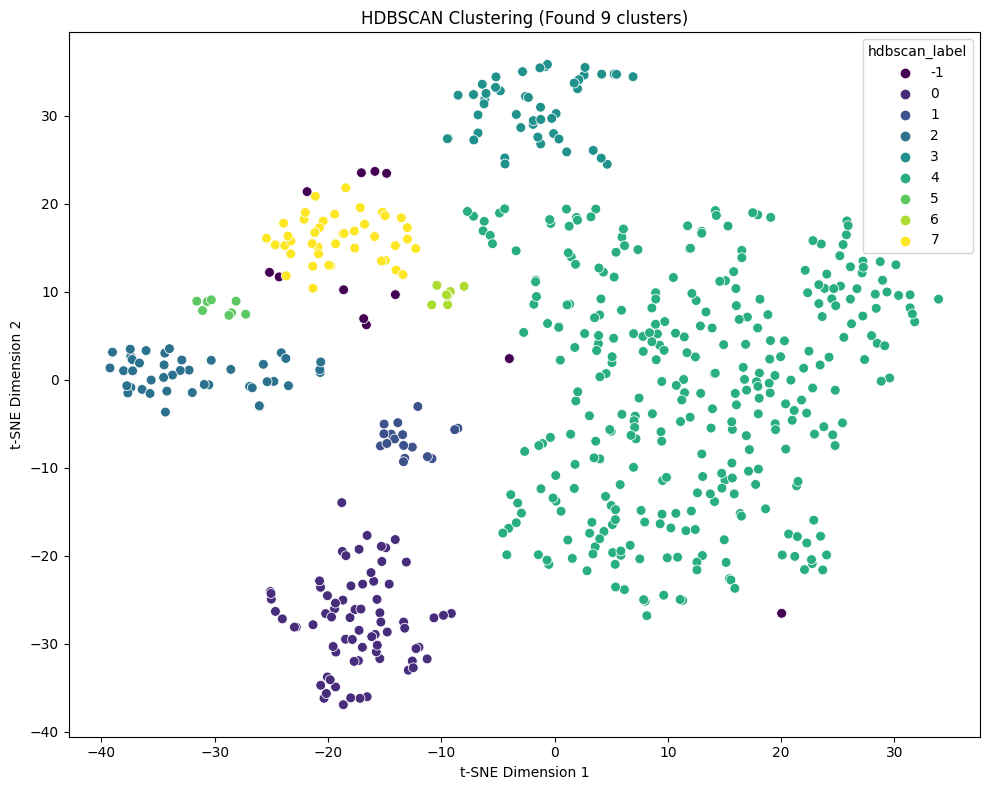

In [3]:
import pandas as pd
import hdbscan
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure the first column name in your data_string is 'sample_id' or adjust accordingly
tsne_df = tsne_result

# Select the columns containing the coordinates for clustering
coordinates = tsne_df[['tSNE1', 'tSNE2']]

# --- 2. HDBSCAN Clustering ---
# min_cluster_size is a key parameter to tune. Smaller values allow smaller clusters.
# min_samples controls how conservative the clustering is (larger values = more points declared as noise).
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=None, gen_min_span_tree=True) # Default values
tsne_df['hdbscan_label'] = hdbscan_clusterer.fit_predict(coordinates)

# HDBSCAN labels noise points as -1
n_clusters_hdbscan = len(set(tsne_df['hdbscan_label'])) - (1 if -1 in tsne_df['hdbscan_label'] else 0)
n_noise_hdbscan = list(tsne_df['hdbscan_label']).count(-1)
print(f"HDBSCAN found {n_clusters_hdbscan} clusters and {n_noise_hdbscan} noise points.")

# Plot HDBSCAN results
plt.figure(figsize=(10, 8))
scatter_hdb = sns.scatterplot(
    data=tsne_df,
    x='tSNE1',
    y='tSNE2',
    hue='hdbscan_label',
    palette='viridis', # Use a qualitative palette if you have many clusters
    legend='full',
    s=50 # Adjust size
)
plt.title(f'HDBSCAN Clustering (Found {n_clusters_hdbscan} clusters)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# Move legend out
# scatter_hdb.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.tight_layout()
plt.savefig('tsne_results_best_params/hdbscan_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

KMeans assigned points to 2 clusters.


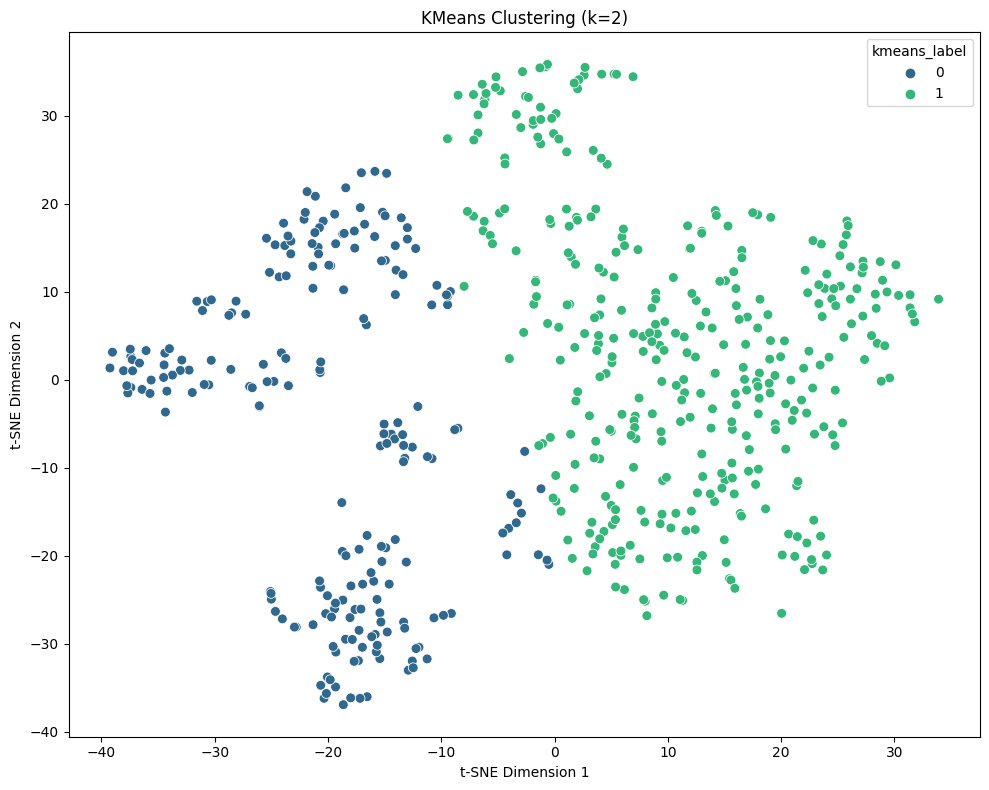

In [4]:
# --- 3. KMeans Clustering ---
k = 2
kmeans_clusterer = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' in newer sklearn
tsne_df['kmeans_label'] = kmeans_clusterer.fit_predict(coordinates)

print(f"KMeans assigned points to {k} clusters.")

# Plot KMeans results in a separate figure
plt.figure(figsize=(10, 8))
scatter_km = sns.scatterplot(
    data=tsne_df,
    x='tSNE1',
    y='tSNE2',
    hue='kmeans_label',
    palette='viridis', # Match palette or choose another
    legend='full',
    s=50
)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# Move legend out
# scatter_km.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.tight_layout()
plt.savefig(f'tsne_results_best_params/kmeans_{k}_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

KMeans assigned points to 3 clusters.


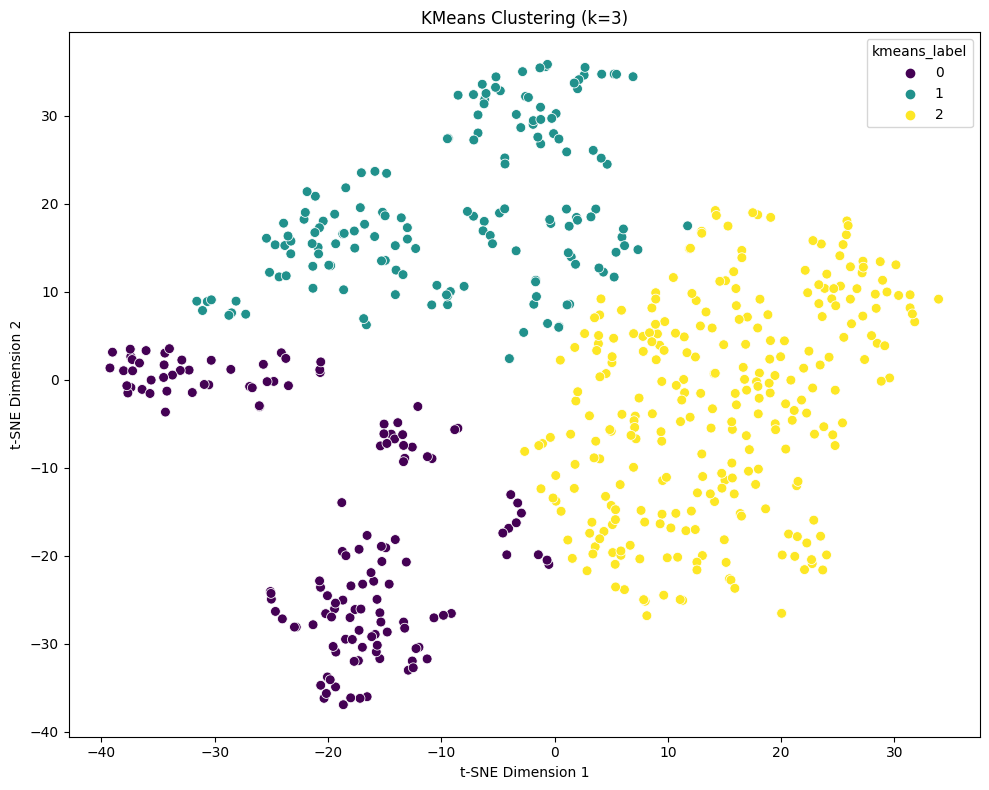

In [5]:
# --- 3. KMeans Clustering ---
k = 3
kmeans_clusterer = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' in newer sklearn
tsne_df['kmeans_label'] = kmeans_clusterer.fit_predict(coordinates)

print(f"KMeans assigned points to {k} clusters.")

# Plot KMeans results in a separate figure
plt.figure(figsize=(10, 8))
scatter_km = sns.scatterplot(
    data=tsne_df,
    x='tSNE1',
    y='tSNE2',
    hue='kmeans_label',
    palette='viridis', # Match palette or choose another
    legend='full',
    s=50
)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# Move legend out
# scatter_km.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.tight_layout()
plt.savefig(f'tsne_results_best_params/kmeans_{k}_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

## UMAP

In [6]:
# check_cols = ["tumor_status", "smoker_status_grouped", "demographic.gender_grouped"]
group_mapping_path = "../data/meta_group.json"

ADATA_PATH = "../data/z-scaled_w_normalized_merged.h5ad"
GROUP_MAPPING_PATH = "../data/meta_group.json"

best_params_sex = {
    "n_neighbors": 5,
    "min_dist": 0.1,
    "spread": 2.0,
    "init": 'random',
    "metric": 'cosine'
}

best_params_smoker = {
    "n_neighbors": 5,
    "min_dist": 0.0,
    "spread": 1.5,
    "metric": 'euclidean',
    "init": 'random'
}

best_params_tumor = {
    "n_neighbors": 30,
    "min_dist": 0.0,
    "spread": 1.5,
    "metric": 'cosine',
    "init": 'spectral'
}

best_params_HDBSCAN = {
    "n_neighbors": 30,
    "min_dist": 0.5,
    "spread": 2.0,
    "metric": 'cosine',
    "init": 'spectral'
}

# Run full analysis with individual plots
print(f"Running t-SNE analysis with metadata grouping from {group_mapping_path}")

# Run with HDBSCAN optimal parameters
adata_grouped, umap_result, umap_path = basic_analysis(
    ADATA_PATH, 
    GROUP_MAPPING_PATH, 
    method_name='umap',
    params=best_params_HDBSCAN,
    output_dir="umap_results_best_params",
    # color_by=check_cols,
    random_state=123
)

Running t-SNE analysis with metadata grouping from ../data/meta_group.json
Loading AnnData from ../data/z-scaled_w_normalized_merged.h5ad
Running umap analysis with metadata grouping from ../data/meta_group.json
Metadata preprocessing complete. Created 19 grouped columns:
  - demographic.country_of_residence_at_enrollment_grouped: 5 groups
    - United States/Canada: 456 observations (79.7%)
    - Germany: 50 observations (8.7%)
    - Australia: 32 observations (5.6%)
    - Russia: 24 observations (4.2%)
    - others: 10 observations (1.7%)
  - demographic.gender_grouped: 2 groups
    - female: 309 observations (54.0%)
    - male: 263 observations (46.0%)
  - demographic.race_grouped: 4 groups
    - white: 440 observations (76.9%)
    - others: 67 observations (11.7%)
    - black or african american: 57 observations (10.0%)
    - asian: 8 observations (1.4%)
  - demographic.vital_status_grouped: 2 groups
    - Alive: 361 observations (63.1%)
    - Dead: 211 observations (36.9%)
  - dia

/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running UMAP with parameters: n_neighbors=30, min_dist=0.5, spread=2.0, metric=cosine, random_state=123


/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP completed in 3.54 seconds
Saved embedding coordinates to: umap_results_best_params/umap_n30_md0.5_sp2.0_metcosine_initspectral/result_coordinates.csv
Saved uncolored plot to: umap_results_best_params/umap_n30_md0.5_sp2.0_metcosine_initspectral/umap_params_uncolored.png
Saved colored plot to: umap_results_best_params/umap_n30_md0.5_sp2.0_metcosine_initspectral/umap_params_smoker_status_grouped.png
Saved colored plot to: umap_results_best_params/umap_n30_md0.5_sp2.0_metcosine_initspectral/umap_params_country_of_residence_at_enrollment_grouped.png
Saved colored plot to: umap_results_best_params/umap_n30_md0.5_sp2.0_metcosine_initspectral/umap_params_gender_grouped.png
Saved colored plot to: umap_results_best_params/umap_n30_md0.5_sp2.0_metcosine_initspectral/umap_params_race_grouped.png
Saved colored plot to: umap_results_best_params/umap_n30_md0.5_sp2.0_metcosine_initspectral/umap_params_vital_status_grouped.png
Saved colored plot to: umap_results_best_params/umap_n30_md0.5_sp2.0_me

/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/sc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 9 clusters and 65 noise points.


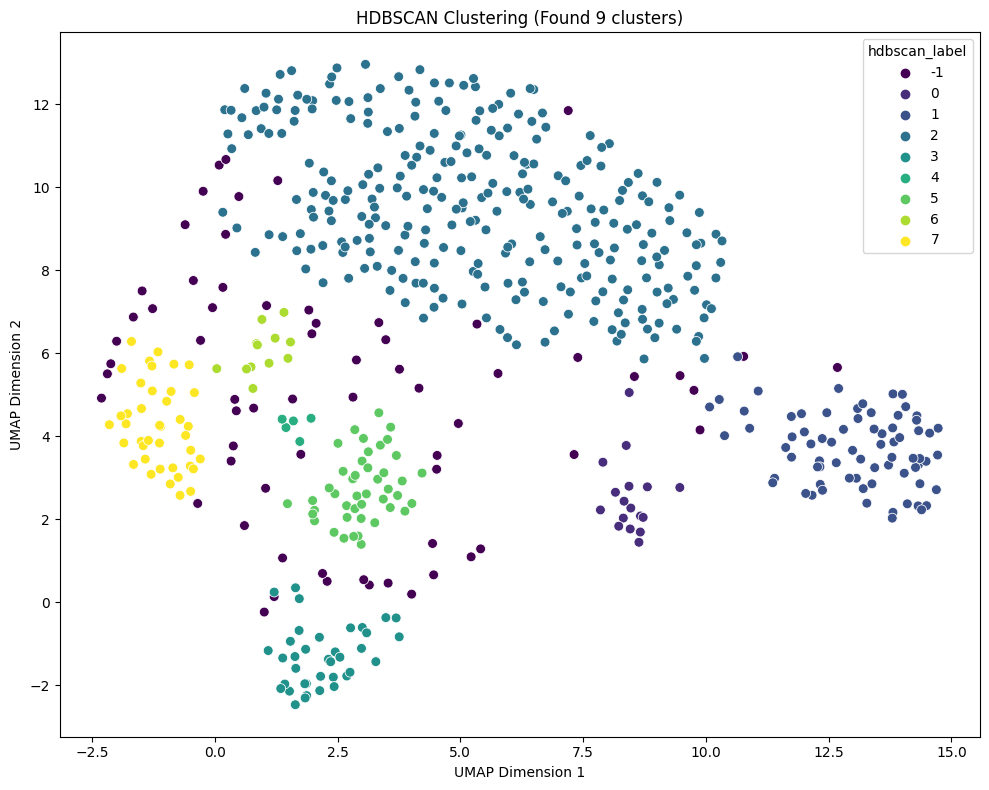

In [8]:
import pandas as pd
import hdbscan
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure the first column name in your data_string is 'sample_id' or adjust accordingly
umap_df = umap_result

# Select the columns containing the coordinates for clustering
coordinates = umap_df[['UMAP1', 'UMAP2']]

# --- 2. HDBSCAN Clustering ---
# min_cluster_size is a key parameter to tune. Smaller values allow smaller clusters.
# min_samples controls how conservative the clustering is (larger values = more points declared as noise).
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=None, gen_min_span_tree=True) # Default values
umap_df['hdbscan_label'] = hdbscan_clusterer.fit_predict(coordinates)

# HDBSCAN labels noise points as -1
n_clusters_hdbscan = len(set(umap_df['hdbscan_label'])) - (1 if -1 in umap_df['hdbscan_label'] else 0)
n_noise_hdbscan = list(umap_df['hdbscan_label']).count(-1)
print(f"HDBSCAN found {n_clusters_hdbscan} clusters and {n_noise_hdbscan} noise points.")

# Plot HDBSCAN results
plt.figure(figsize=(10, 8))
scatter_hdb = sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='hdbscan_label',
    palette='viridis', # Use a qualitative palette if you have many clusters
    legend='full',
    s=50 # Adjust size
)
plt.title(f'HDBSCAN Clustering (Found {n_clusters_hdbscan} clusters)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
# Move legend out
# scatter_hdb.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.tight_layout()
plt.savefig('umap_results_best_params/hdbscan_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

KMeans assigned points to 2 clusters.


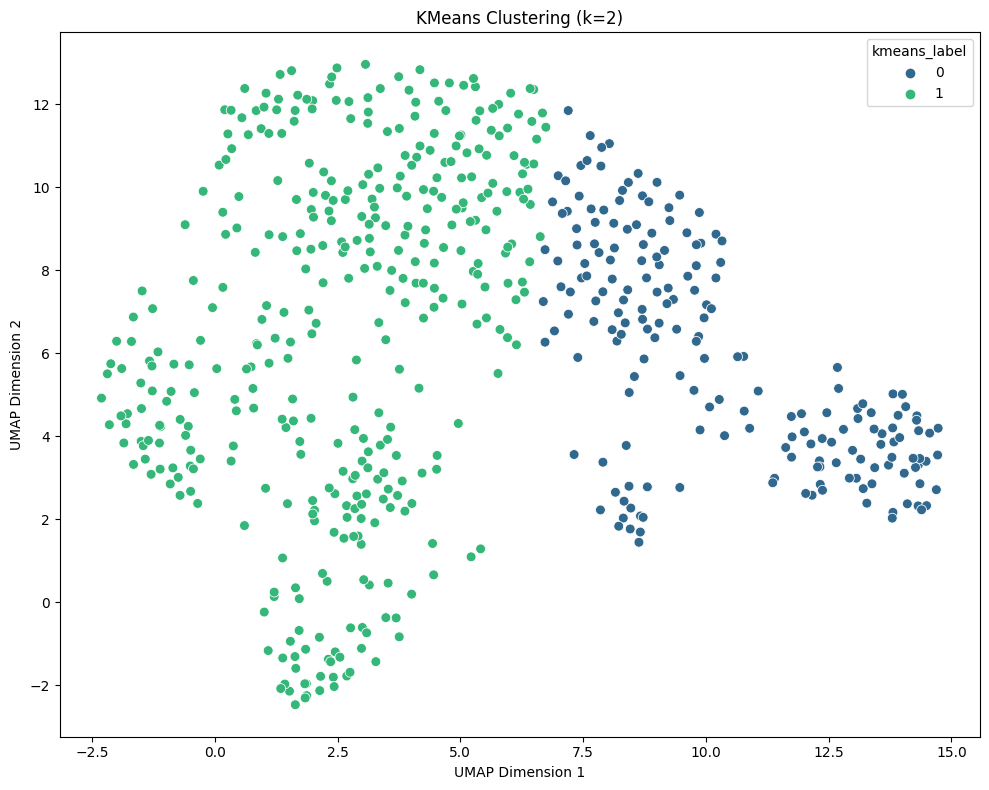

In [9]:
# --- 3. KMeans Clustering ---
k = 2
kmeans_clusterer = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' in newer sklearn
umap_df['kmeans_label'] = kmeans_clusterer.fit_predict(coordinates)

print(f"KMeans assigned points to {k} clusters.")

# Plot KMeans results in a separate figure
plt.figure(figsize=(10, 8))
scatter_km = sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='kmeans_label',
    palette='viridis', # Match palette or choose another
    legend='full',
    s=50
)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
# Move legend out
# scatter_km.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.tight_layout()
plt.savefig(f'umap_results_best_params/kmeans_{k}_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

KMeans assigned points to 3 clusters.


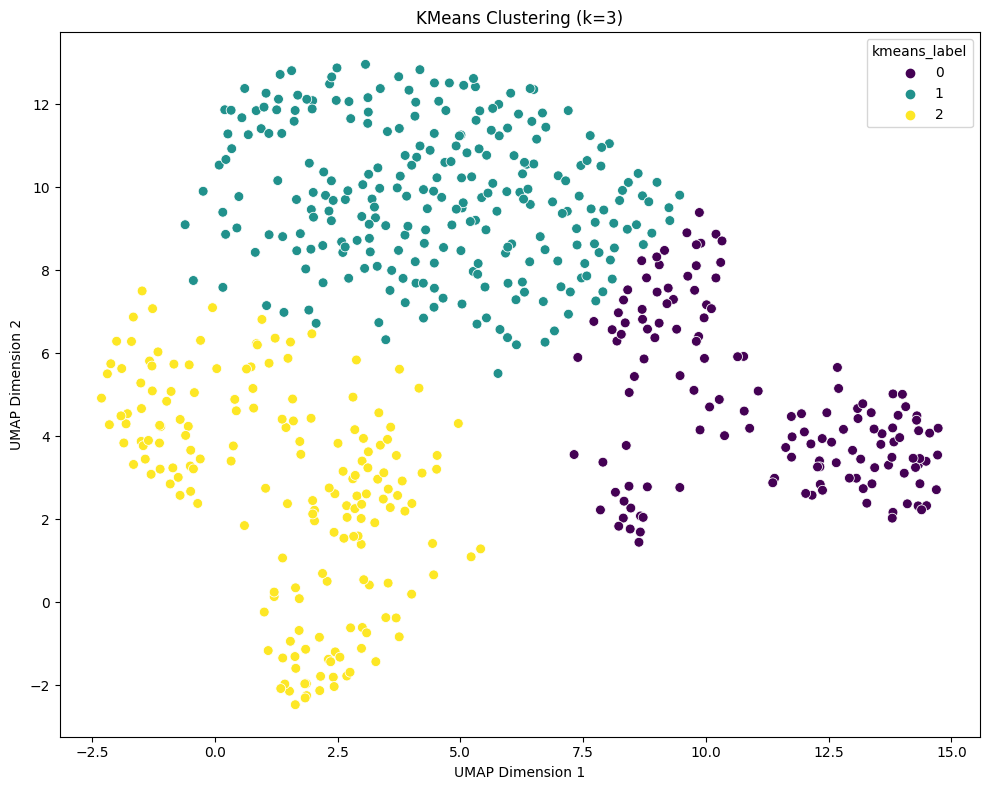

In [10]:
# --- 3. KMeans Clustering ---
k = 3
kmeans_clusterer = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' in newer sklearn
umap_df['kmeans_label'] = kmeans_clusterer.fit_predict(coordinates)

print(f"KMeans assigned points to {k} clusters.")

# Plot KMeans results in a separate figure
plt.figure(figsize=(10, 8))
scatter_km = sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='kmeans_label',
    palette='viridis', # Match palette or choose another
    legend='full',
    s=50
)
plt.title(f'KMeans Clustering (k={k})')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
# Move legend out
# scatter_km.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.tight_layout()
plt.savefig(f'umap_results_best_params/kmeans_{k}_clustering.png', dpi=300, bbox_inches='tight')
plt.show()